# Algorithmic Trading Model with ML4T SEC's EDGAR Filing Examples¶
### David Lowe¶
### June 29, 2022¶

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the examples found in chapter one of the book Machine Learning for Algorithmic Trading by Stefan Jansen. The script seeks to validate further the Python environment and package requirements for running these code examples. The eventual goal is to integrate various example code segments into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: US Public Company Filing Hosted by SEC's EDGAR Service

Source and Further Discussion of the Code Examples: https://www.ml4trading.io/chapter/1

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os
from dotenv import load_dotenv
from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
# Set up the dotenv file for retrieving environment variables
env_path = "/Users/david/PycharmProjects/ml4tVenv/"
dotenv_path = env_path + "ml4t.env"
load_dotenv(dotenv_path=dotenv_path)

True

In [4]:
sns.set_style('whitegrid')

In [5]:
# store data in this directory since we won't use it in other chapters
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes Data

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets from Q1/2018 through Q4/2020.

> The SEC has moved to a monthly cadence after Q3/2020; feel free to extend the code by creating the correpsonding file names (see linked website) and download those as well.

**Downloads over 10GB of data for just one year!**

In [6]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [7]:
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2020', '2020-12-31', freq='Q')]
filing_periods

[(2020, 1), (2020, 2), (2020, 3), (2020, 4)]

In [8]:
for yr, qtr in tqdm(filing_periods):
    # set (and create) directory
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(parents=True)
    
    # define url and get file
    filing = f'{yr}q{qtr}_notes.zip'
    url = SEC_URL + FSN_PATH + filing
    response = requests.get(url).content
    
    # decompress and save
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        print(f'\nBad zip file: {yr} {qtr}\n')
        continue

100%|██████████| 4/4 [01:14<00:00, 18.63s/it]


## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

> Some fo the `txt.tsv` source files contain a small number of faulty lines; the code below drops those lines but indicates the line numbers where you can find the errors if you would like to investigate further. 

In [9]:
for f in tqdm(sorted(list(data_path.glob('**/*.tsv')))):
    # set (and create) directory
    parquet_path = f.parent.parent / 'parquet'
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)    

    # write content to .parquet
    file_name = f.stem  + '.parquet'
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, ' | ', f)
        # optional: uncomment to delete original .tsv
#         else:
            # f.unlink

100%|██████████| 32/32 [00:00<00:00, 7997.72it/s]


## Metadata json

In [10]:
filename = os.path.join(data_path, "2020_1", "source", "2020q1_notes-metadata.json")
with open(filename, mode="r") as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries.

In [11]:
sub = pd.read_parquet(os.path.join(data_path, '2020_1', 'parquet', 'sub.parquet'))
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13561 entries, 0 to 13560
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         13561 non-null  object 
 1   cik          13561 non-null  int64  
 2   name         13561 non-null  object 
 3   sic          13557 non-null  float64
 4   countryba    13545 non-null  object 
 5   stprba       12623 non-null  object 
 6   cityba       13544 non-null  object 
 7   zipba        13542 non-null  object 
 8   bas1         13545 non-null  object 
 9   bas2         5409 non-null   object 
 10  baph         13547 non-null  object 
 11  countryma    13489 non-null  object 
 12  stprma       12636 non-null  object 
 13  cityma       13489 non-null  object 
 14  zipma        13477 non-null  object 
 15  mas1         13487 non-null  object 
 16  mas2         5354 non-null   object 
 17  countryinc   12378 non-null  object 
 18  stprinc      11710 non-null  object 
 19  ein 

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [12]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'filed']
apple.loc[key_cols]

,1758,1934,4910,7352
name,APPLE INC,APPLE INC,APPLE INC,APPLE INC
adsh,0000320193-20-000008,0000320193-20-000010,0001193125-20-039203,0001193125-20-050884
cik,320193,320193,320193,320193
name,APPLE INC,APPLE INC,APPLE INC,APPLE INC
sic,3571.0,3571.0,3571.0,3571.0
countryba,US,US,US,US
stprba,CA,CA,CA,CA
cityba,CUPERTINO,CUPERTINO,CUPERTINO,CUPERTINO
zipba,95014,95014,95014,95014
bas1,ONE APPLE PARK WAY,ONE APPLE PARK WAY,ONE APPLE PARK WAY,ONE APPLE PARK WAY


## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [13]:
apple_cik = apple.loc['cik'].to_list()[0]
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple_cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])
aapl_subs.form.value_counts()

10-Q    3
10-K    1
Name: form, dtype: int64

We find 3 quarterly 10-Q and 1 annual 10-K reports:

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [14]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

784
1017
1028
1223


In total, the one year of filing history provide us with over 4,000 numerical values for AAPL.

In [15]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4052 entries, 273541 to 3364728
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      4052 non-null   object        
 1   tag       4052 non-null   object        
 2   version   4052 non-null   object        
 3   ddate     4052 non-null   datetime64[ns]
 4   qtrs      4052 non-null   int64         
 5   uom       4052 non-null   object        
 6   iprx      4052 non-null   int64         
 7   value     4044 non-null   float64       
 8   footnote  0 non-null      object        
 9   footlen   4052 non-null   int64         
 10  dimn      4052 non-null   int64         
 11  coreg     0 non-null      object        
 12  durp      4052 non-null   float64       
 13  datp      4052 non-null   float64       
 14  dcml      4052 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 506.5+ KB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [16]:
# stock_split = 7
# split_date = pd.to_datetime('20140604')
# split_date

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [17]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
# eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
# eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

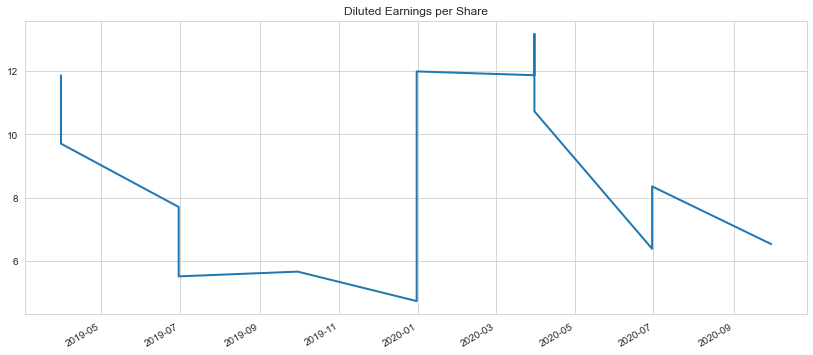

In [18]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [19]:
print(eps.index.min())

2019-03-31 00:00:00


In [20]:
symbol = 'AAPL'

# aapl_stock = (web.
#               DataReader(symbol, 'av-daily', start=eps.index.min(), api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
#               .resample('D')
#               .last()
#               .loc['2019':eps.index.max()])
stock_data = web.DataReader(symbol, 'av-daily', '2020-01-01', '2020-12-31', api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
stock_data.index = pd.to_datetime(stock_data.index)
aapl_stock = stock_data.resample('D').last().loc['2019':eps.index.max()]

aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2020-01-02 to 2020-09-30
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    189 non-null    float64
 1   high    189 non-null    float64
 2   low     189 non-null    float64
 3   close   189 non-null    float64
 4   volume  189 non-null    float64
dtypes: float64(5)
memory usage: 12.8 KB


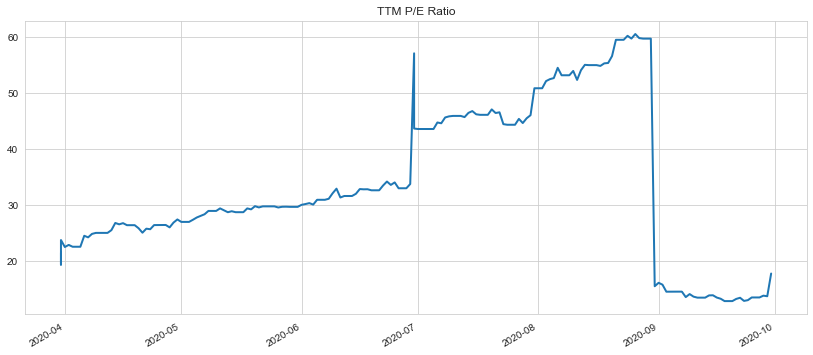

In [21]:
pe = aapl_stock.close.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [22]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2020-03-31 to 2020-09-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      188 non-null    float64
 1   eps        188 non-null    float64
 2   P/E Ratio  188 non-null    float64
dtypes: float64(3)
memory usage: 5.9 KB


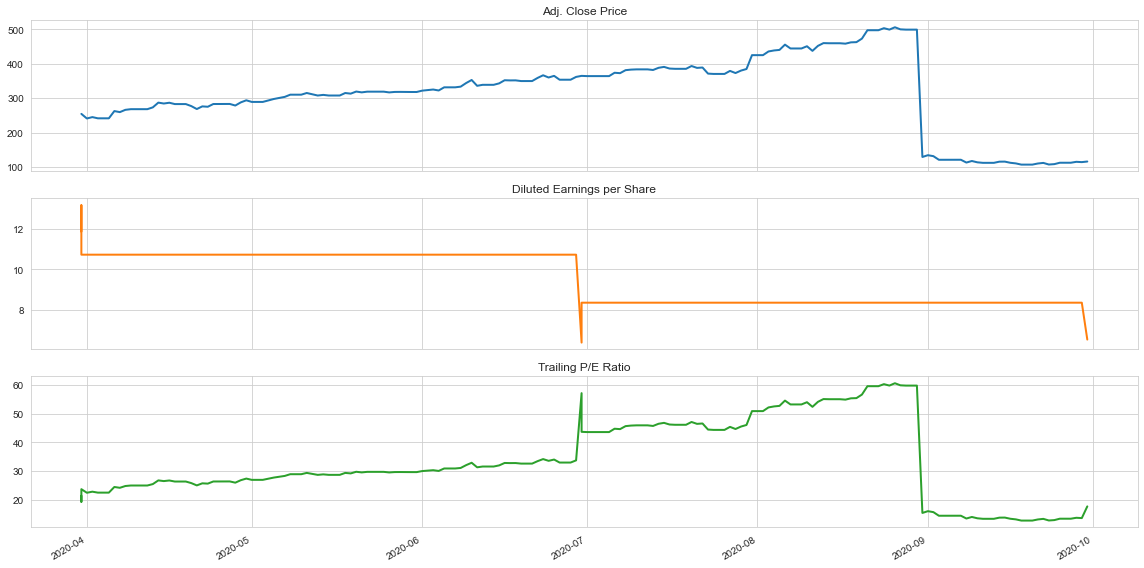

In [23]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [24]:
aapl_nums.tag.value_counts()

RevenueFromContractWithCustomerExcludingAssessedTax                                           202
StockholdersEquity                                                                            164
CashAndCashEquivalentsAtCarryingValue                                                         120
MarketableSecuritiesCurrent                                                                   112
MarketableSecuritiesNoncurrent                                                                112
                                                                                             ... 
UnrecordedUnconditionalPurchaseObligationBalanceOnFifthAnniversary                              1
DefinedContributionPlanMaximumAnnualContributionsPerEmployeeAmount                              1
LongTermDebtMaturitiesRepaymentsOfPrincipalInYearFour                                           1
FinanceLeaseLiabilityPaymentsDueNextTwelveMonths                                                1
SharebasedCompensati

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [25]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividends',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

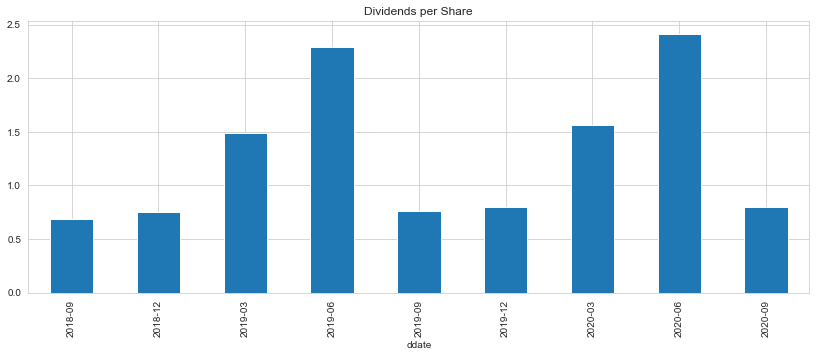

In [26]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividends', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [27]:
txt = pd.read_parquet(os.path.join(data_path, '2020_2', 'parquet', 'txt.parquet'))

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statements here:

In [28]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000006201-20-000051,AmendmentFlag,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,5,5,None,0,D2020Q2,false
1,0000006201-20-000051,AmendmentFlag,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0xbcb3e4b456b208133382b5ccc841019f,1,None,0,5,5,None,0,D2020Q2_srt_ConsolidatedEntitiesAxis_srt_Subsi...,false
2,0000006201-20-000051,EntityCentralIndexKey,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,10,10,None,0,D2020Q2,0000006201
3,0000006201-20-000051,EntityCentralIndexKey,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0xbcb3e4b456b208133382b5ccc841019f,1,None,0,10,10,None,0,D2020Q2_srt_ConsolidatedEntitiesAxis_srt_Subsi...,0000004515
4,0000006201-20-000051,DocumentType,dei/2019,20200331,0,0,en-US,32767,0.0,-1.0,0x00000000,0,None,0,3,3,None,0,D2020Q2,8-K
